#G/G/1 Model implementation and sample plots

Author: Ufuk Usubutun

usubutun[at]nyu[dot]edu

Supplementary material for our article "Backbone Switches No Longer Need To Deliver Packets in Sequence" (U. Usubutun, F. Fund, S. S. Panwar)

This notebook implements
* The G/G/1 approximation technique as proposed by Whitt in his QNA work.
* Produces plots for our G/G/1 model capturing a load balanced switch with N parallel queues


Please note that the parameter $p$ in this notebook is equivalent to $1-p$ in the paper.

In [10]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import numpy as np
from scipy.special import gamma

import seaborn as sns
sns.set()
sns.set_style("white")


In [11]:
def gg1_avg_delay(c_arr_2, c_serv_2, rho, mean_serv_rate):
    c_arr_2 = np.asarray(c_arr_2)
    rho = np.asarray(rho)

    g = np.where(
        c_arr_2 < 1,
        np.exp(-2 * (1 - rho) * (1 - c_arr_2)**2 / (3 * rho * (c_arr_2 + c_serv_2))),
        1.0
    )
    exp_wait = (1 / mean_serv_rate) * rho * (c_arr_2 + c_serv_2) * g / (2 * (1 - rho))
    return exp_wait

def gg1_fdFd(cD_2s, x, exp_delays, var_Ds):
    x = np.asarray(x)

    if cD_2s > 1.01:
        # case 1
        p = (1 + np.sqrt((cD_2s - 1) / (cD_2s + 1))) / 2
        gam1 = 2 * p / exp_delays
        gam2 = 2 * (1 - p) / exp_delays

        f_D = p * gam1 * np.exp(-gam1 * x) + (1 - p) * gam2 * np.exp(-gam2 * x)
        F_D = p * (1 - np.exp(-gam1 * x)) + (1 - p) * (1 - np.exp(-gam2 * x))

    elif cD_2s > 0.99:
        # case 2
        gam1 = 1 / exp_delays

        f_D = gam1 * np.exp(-gam1 * x)
        F_D = 1 - np.exp(-gam1 * x)

    elif cD_2s > 0.501:
        # case 3
        gam2 = 1 / ((exp_delays + np.sqrt(2 * var_Ds - exp_delays**2)) / 2)
        gam1 = 1 / (exp_delays - 1 / gam2)

        f_D = (gam1 * gam2 / (gam1 - gam2)) * (np.exp(-gam2 * x) - np.exp(-gam1 * x))
        F_D = 1 - ((gam1 * np.exp(-gam2 * x) - gam2 * np.exp(-gam1 * x)) / (gam1 - gam2))

    else:
        # case 4
        gam1 = 2 / exp_delays

        f_D = gam1**2 * x * np.exp(-gam1 * x)
        F_D = 1 - np.exp(-gam1 * x) * (1 + gam1 * x)

    return f_D, F_D


In [12]:

def compute_gg1_delay_distribution(p=0.4, capacity=400.5e9, rho=0.99, k_wei=0.8, x=None, return_stats=False):
    if x is None:
        x = np.logspace(-9, 1, 500)

    avg_pkt_size = (p * 64 + (1 - p) * 1518) * 8
    T = avg_pkt_size / capacity
    Cp = 1 / T

    short_service_time = 64 * 8 / capacity
    long_service_time = 1518 * 8 / capacity

    arr_rate = rho * Cp
    mean_interarr_time = 1 / arr_rate
    lam_wei = mean_interarr_time / gamma(1 + 1 / k_wei)

    c_arr_2 = gamma(1 + 2 / k_wei) / gamma(1 + 1 / k_wei)**2 - 1

    ds_3 = (p * short_service_time**3 + (1 - p) * long_service_time**3) / \
           (p * short_service_time + (1 - p) * long_service_time)**3
    c_serv_2 = (p * short_service_time**2 + (1 - p) * long_service_time**2) / \
               (p * short_service_time + (1 - p) * long_service_time)**2 - 1

    exp_wait = gg1_avg_delay(c_arr_2, c_serv_2, rho, Cp)
    exp_delay = exp_wait / rho

    cD_2 = 2 * rho - 1 + 4 * (1 - rho) * ds_3 / (3 * (c_serv_2 + 1)**2)
    var_D = exp_delay**2 * cD_2
    exp_D_2 = var_D + exp_delay**2

    f_D, F_D = gg1_fdFd(cD_2, x, exp_delay, var_D)

    if return_stats:
        return f_D, F_D, x, c_arr_2
    return f_D, F_D, x


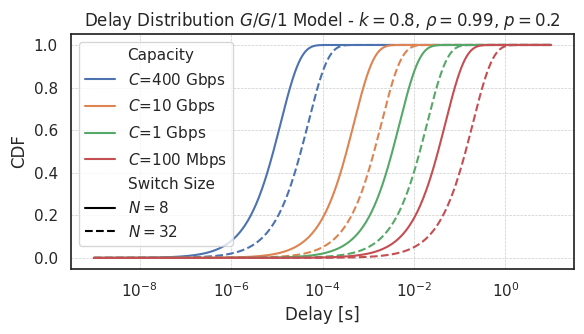

In [13]:
import matplotlib.pyplot as plt

# Parameters
N_1 = 8
N_2 = 32
p=0.8
k_wei=0.8
rho=0.99


# Plot
plt.figure(figsize=(6, 3.5))


plt.plot([np.nan], [np.nan], label="Capacity", color='none', linestyle='None')

total_capacity = 400e9  # Total capacity before division
N = N_1
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
line, = plt.semilogx(x, F_D,
             label=fr'$C$={total_capacity/1e9:.0f} Gbps')
color= line.get_color()

N = N_2
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
plt.semilogx(x, F_D, color=color, linestyle='--',label='_nolegend_')


total_capacity = 10e9  # Total capacity before division
N = N_1
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
line, = plt.semilogx(x, F_D,
             label=fr'$C$={total_capacity/1e9:.0f} Gbps')
color = line.get_color()

N = N_2
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
plt.semilogx(x, F_D, color=color, linestyle='--',label='_nolegend_')




total_capacity = 1e9  # Total capacity before division
N = N_1
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
line, = plt.semilogx(x, F_D,
             label=fr'$C$={total_capacity/1e9:.0f} Gbps')
color = line.get_color()

N = N_2
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
plt.semilogx(x, F_D, color=color, linestyle='--',label='_nolegend_')




total_capacity = 0.1e9  # Total capacity before division
N = N_1
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
line, = plt.semilogx(x, F_D,
             label=fr'$C$={total_capacity/1e6:.0f} Mbps')
color = line.get_color()

total_capacity = 0.1e9  # Total capacity before division
N = N_2
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
plt.semilogx(x, F_D, color=color, linestyle='--',label='_nolegend_')


# --- Create a blank spacer entry ---
plt.plot([np.nan], [np.nan], label="Switch Size", color='none', linestyle='None')


plt.plot([np.nan], [np.nan], label=f'$N={N_1}$', color='black', linestyle='-')
plt.plot([np.nan], [np.nan], label=f'$N={N_2}$', color='black', linestyle='--')



plt.xlabel("Delay [s]")
plt.ylabel("CDF")
plt.title(fr"Delay Distribution $G/G/1$ Model - $k={k_wei}$, $\rho={rho}$, $p={1-p:.1f}$")
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

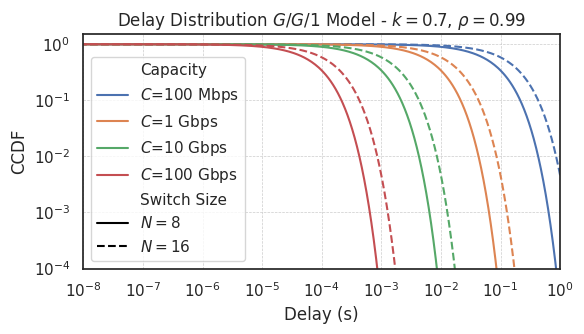

In [14]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Parameters
N_1 = 8
N_2 = 16
p=0.2
k_wei=0.7
rho=0.99


# Plot
plt.figure(figsize=(6, 3.5))


plt.plot([np.nan], [np.nan], label="Capacity", color='none', linestyle='None')



total_capacity = 0.1e9  # Total capacity before division
N = N_1
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
line, = plt.loglog(x, 1-F_D,
             label=fr'$C$={total_capacity/1e6:.0f} Mbps')
color = line.get_color()

total_capacity = 0.1e9  # Total capacity before division
N = N_2
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
plt.loglog(x, 1-F_D, color=color, linestyle='--',label='_nolegend_')



total_capacity = 1e9  # Total capacity before division
N = N_1
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
line, = plt.loglog(x, 1-F_D,
             label=fr'$C$={total_capacity/1e9:.0f} Gbps')
color = line.get_color()

N = N_2
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
plt.loglog(x, 1-F_D, color=color, linestyle='--',label='_nolegend_')






total_capacity = 10e9  # Total capacity before division
N = N_1
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
line, = plt.loglog(x, 1-F_D,
             label=fr'$C$={total_capacity/1e9:.0f} Gbps')
color = line.get_color()

N = N_2
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
plt.loglog(x, 1-F_D, color=color, linestyle='--',label='_nolegend_')




total_capacity = 100e9  # Total capacity before division
N = N_1
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
line, = plt.loglog(x, 1-F_D,
             label=fr'$C$={total_capacity/1e9:.0f} Gbps')
color= line.get_color()

N = N_2
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
plt.loglog(x, 1-F_D, color=color, linestyle='--',label='_nolegend_')




plt.plot([np.nan], [np.nan], label="Switch Size", color='none', linestyle='None')


plt.plot([np.nan], [np.nan], label=f'$N={N_1}$', color='black', linestyle='-')
plt.plot([np.nan], [np.nan], label=f'$N={N_2}$', color='black', linestyle='--')


plt.xlabel("Delay (s)")
plt.ylabel("CCDF")
plt.title(fr"Delay Distribution $G/G/1$ Model - $k={k_wei}$, $\rho={rho}$") #, $p={1-p:.1f}$")
plt.legend(loc="lower left")
plt.ylim((1e-4,1.5))
plt.xlim((1e-8,1e0))
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
#plt.savefig(f"model_delay_predict_C_rho099_k07.pdf")
plt.show()

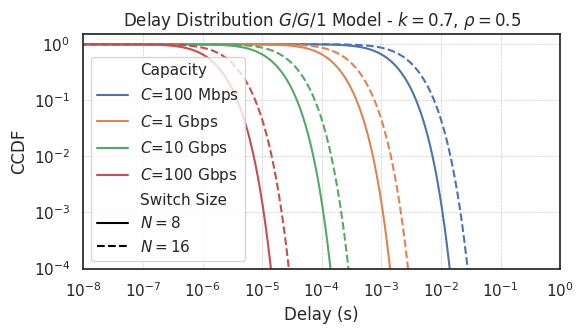

In [15]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Parameters
N_1 = 8
N_2 = 16
p=0.2
k_wei=0.7
rho=0.5


fig, ax = plt.subplots(figsize=(6, 3.5))

plt.plot([np.nan], [np.nan], label="Capacity", color='none', linestyle='None')



total_capacity = 0.1e9  # Total capacity before division
N = N_1
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
line, = plt.loglog(x, 1-F_D,
             label=fr'$C$={total_capacity/1e6:.0f} Mbps')
color = line.get_color()

total_capacity = 0.1e9  # Total capacity before division
N = N_2
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
plt.loglog(x, 1-F_D, color=color, linestyle='--',label='_nolegend_')



total_capacity = 1e9  # Total capacity before division
N = N_1
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
line, = plt.loglog(x, 1-F_D,
             label=fr'$C$={total_capacity/1e9:.0f} Gbps')
color = line.get_color()

N = N_2
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
plt.loglog(x, 1-F_D, color=color, linestyle='--',label='_nolegend_')






total_capacity = 10e9  # Total capacity before division
N = N_1
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
line, = plt.loglog(x, 1-F_D,
             label=fr'$C$={total_capacity/1e9:.0f} Gbps')
color = line.get_color()

N = N_2
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
plt.loglog(x, 1-F_D, color=color, linestyle='--',label='_nolegend_')





total_capacity = 100e9  # Total capacity before division
N = N_1
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
line, = plt.loglog(x, 1-F_D,
             label=fr'$C$={total_capacity/1e9:.0f} Gbps')
color= line.get_color()

N = N_2
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
plt.loglog(x, 1-F_D, color=color, linestyle='--',label='_nolegend_')



plt.plot([np.nan], [np.nan], label="Switch Size", color='none', linestyle='None')



plt.plot([np.nan], [np.nan], label=f'$N={N_1}$', color='black', linestyle='-')
plt.plot([np.nan], [np.nan], label=f'$N={N_2}$', color='black', linestyle='--')


plt.xlabel("Delay (s)")
plt.ylabel("CCDF")
plt.title(fr"Delay Distribution $G/G/1$ Model - $k={k_wei}$, $\rho={rho}$") #, $p={1-p:.1f}$")
plt.legend(loc="lower left")
plt.ylim((1e-4,1.5))
plt.xlim((1e-8,1e0))
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
#plt.savefig(f"model_delay_predict_C_lowrho2_k07.pdf")
plt.show()

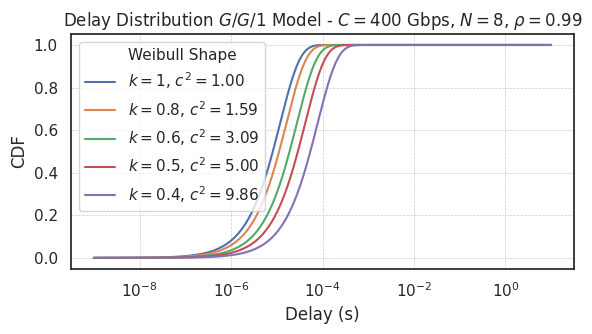

In [16]:
import matplotlib.pyplot as plt

# Parameters

p=0.4
rho=0.99
total_capacity = 400e9  # Total capacity before division
N = 8

# Plot
plt.figure(figsize=(6, 3.5))

plt.plot([np.nan], [np.nan], label="Weibull Shape", color='none', linestyle='None')

k_wei=1

# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
plt.semilogx(x, F_D,
             label=fr'$k={k_wei}$, $c^2={c_arr_2:.2f}$')

k_wei=0.8
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
plt.semilogx(x, F_D,
             label=fr'$k={k_wei}$, $c^2={c_arr_2:.2f}$')

k_wei=0.6
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
plt.semilogx(x, F_D,
             label=fr'$k={k_wei}$, $c^2={c_arr_2:.2f}$')

k_wei=0.5
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
plt.semilogx(x, F_D,
             label=fr'$k={k_wei}$, $c^2={c_arr_2:.2f}$')

k_wei=0.4
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
plt.semilogx(x, F_D,
             label=fr'$k={k_wei}$, $c^2={c_arr_2:.2f}$')



plt.xlabel("Delay (s)")
plt.ylabel("CDF")
plt.title(rf"Delay Distribution $G/G/1$ Model - $C={total_capacity/1e9:.0f}$ Gbps, $N={N}$, $\rho={rho}$")
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

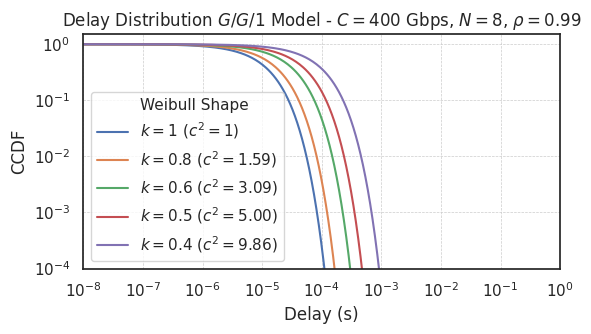

In [17]:
import matplotlib.pyplot as plt

# Parameters

p=0.2
rho=0.99
total_capacity = 400e9  # Total capacity before division
N = 8

# Plot
plt.figure(figsize=(6, 3.5))

plt.plot([np.nan], [np.nan], label="Weibull Shape", color='none', linestyle='None')

k_wei=1

# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
plt.loglog(x, 1-F_D,
             label=fr'$k={k_wei}$ ($c^2={c_arr_2:.0f}$)')

k_wei=0.8
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
plt.loglog(x, 1-F_D,
             label=fr'$k={k_wei}$ ($c^2={c_arr_2:.2f}$)')

k_wei=0.6
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
plt.loglog(x, 1-F_D,
             label=fr'$k={k_wei}$ ($c^2={c_arr_2:.2f}$)')

k_wei=0.5
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
plt.loglog(x, 1-F_D,
             label=fr'$k={k_wei}$ ($c^2={c_arr_2:.2f}$)')

k_wei=0.4
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
plt.loglog(x, 1-F_D,
             label=fr'$k={k_wei}$ ($c^2={c_arr_2:.2f}$)')



plt.xlabel("Delay (s)")
plt.ylabel("CCDF")
plt.title(rf"Delay Distribution $G/G/1$ Model - $C={total_capacity/1e9:.0f}$ Gbps, $N={N}$, $\rho={rho}$")
plt.legend(loc="lower left")
plt.ylim((1e-4,1.5))
plt.xlim((1e-8,1))
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
#plt.savefig(f"model_delay_predict_k.pdf")
plt.show()

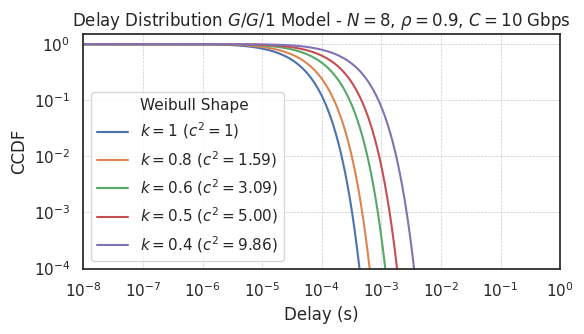

In [18]:
import matplotlib.pyplot as plt

# Parameters

p=0.2
total_capacity = 10e9  # Total capacity before division
N = 8

# Plot
plt.figure(figsize=(6, 3.5))

plt.plot([np.nan], [np.nan], label="Weibull Shape", color='none', linestyle='None')

k_wei=1
rho=0.9
total_capacity = 10e9  # Total capacity before division


# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
line, = plt.loglog(x, 1-F_D,
             label=fr'$k={k_wei}$ ($c^2={c_arr_2:.0f}$)')
color = line.get_color()



k_wei=0.8
total_capacity = 10e9  # Total capacity before division

#rho=0.9
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
plt.loglog(x, 1-F_D,
             label=fr'$k={k_wei}$ ($c^2={c_arr_2:.2f}$)')

k_wei=0.6
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
plt.loglog(x, 1-F_D,
             label=fr'$k={k_wei}$ ($c^2={c_arr_2:.2f}$)')

k_wei=0.5
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
plt.loglog(x, 1-F_D,
             label=fr'$k={k_wei}$ ($c^2={c_arr_2:.2f}$)')

k_wei=0.4
# Compute distribution and extract c_arr_2
f_D, F_D, x, c_arr_2 = compute_gg1_delay_distribution(p=p, capacity=total_capacity/N, rho=rho, k_wei=k_wei, x=None, return_stats=True)
plt.loglog(x, 1-F_D,
             label=fr'$k={k_wei}$ ($c^2={c_arr_2:.2f}$)')



plt.xlabel("Delay (s)")
plt.ylabel("CCDF")
plt.title(rf"Delay Distribution $G/G/1$ Model - $N={N}$, $\rho={rho}$, $C={total_capacity/1e9:.0f}$ Gbps")
plt.legend(loc="lower left")
plt.ylim((1e-4,1.5))
plt.xlim((1e-8,1e0))
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
#plt.savefig(f"model_delay_predict_k_v5.pdf")
plt.show()